## Package

In [1]:
!pip install fastai -Uqq

     |████████████████████████████████| 197 kB 30.5 MB/s 
     |████████████████████████████████| 60 kB 9.4 MB/s 


In [2]:
from fastai.vision.all import *

# ResNets

In [3]:
url = URLs.IMAGENETTE_160
path = untar_data(url)

In [4]:
def get_data(path, presize, resize):
  return DataBlock(
      blocks = (ImageBlock, CategoryBlock),
      get_items = get_image_files,
      splitter = GrandparentSplitter(valid_name = 'val'),
      get_y = parent_label,
      item_tfms = Resize(presize),
      batch_tfms = [*aug_transforms(min_scale=.5, size = resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs = 128)

In [5]:
dls = get_data(path, 160, 128)

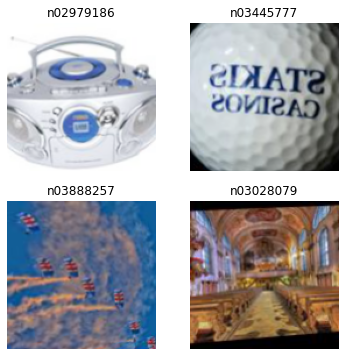

In [6]:
dls.show_batch(max_n = 4)

In [7]:
def block(ni, nf): 
  return ConvLayer(ni, nf, stride=2)

def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

In [8]:
def get_learner(m):
  return Learner(dls, m, 
                 loss_func = nn.CrossEntropyLoss(), 
                 metrics = accuracy).to_fp16()

In [9]:
learn = get_learner(get_model())

SuggestedLRs(valley=0.0004786300996784121)

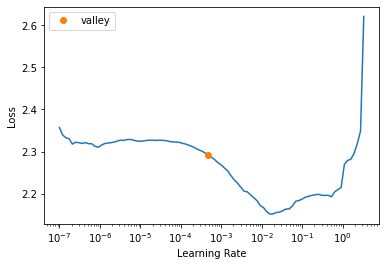

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(5, 4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.850930,2.021389,0.330446,00:27
1,1.509452,1.405761,0.554395,00:25
2,1.293746,1.188797,0.622675,00:26
3,1.120525,1.042138,0.669809,00:26
4,1.010590,1.028319,0.676943,00:26


## Building a Modern CNN: ResNet

### Skip connections

In [10]:
class ResBlock(Module):
  def __init__(self, ni, nf):
    self.convs = nn.Sequential(
        ConvLayer(ni, nf),
        ConvLayer(nf, nf, norm_type=NormType.BatchZero)
    )

  def forward(self, x):
    return x + self.convs(x)

In [11]:
def _conv_block(ni, nf, stride):
  seq = nn.Sequential(
      ConvLayer(ni, nf, stride = stride),
      ConvLayer(nf, nf, act_cls = None, norm_type = NormType.BatchZero)
  )
  return seq

In [12]:
class ResBlock(Module):
  def __init__(self, ni, nf, stride = 1):
    self.convs = _conv_block(ni, nf, stride)
    self.idconv = noop if ni == nf else ConvLayer(ni, nf, 1, act_cls = None)
    self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

  def forward(self, x):
    return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [13]:
def block(ni, nf):
  return ResBlock(ni, nf, stride = 2)

In [16]:
learn = get_learner(get_model())

In [17]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.959062,2.051467,0.309554,00:28
1,1.675067,1.452789,0.530701,00:30
2,1.374194,1.208507,0.619108,00:27
3,1.146261,1.042419,0.670064,00:27
4,1.017944,0.991786,0.687643,00:27


In [14]:
def block(ni, nf):
  return nn.Sequential(ResBlock(ni, nf, stride=2), ResBlock(nf, nf))

In [19]:
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.952376,1.931908,0.321783,00:28
1,1.619059,1.539428,0.491975,00:28
2,1.327625,1.331919,0.572994,00:27
3,1.097483,1.072326,0.657834,00:27
4,0.948385,0.940756,0.700637,00:27


### A state of the Art ResNet

In [15]:
def _resnet_stem(*sizes):
  stem = [
          ConvLayer(sizes[i], sizes[i+1], stride = 2 if i == 0 else 1)
          for i in range(len(sizes) - 1)
  ] + [nn.MaxPool2d(kernel_size=3, stride = 2, padding = 1)]

  return stem

In [21]:
_resnet_stem(3,32,32,64)

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

In [16]:
class ResNet(nn.Sequential):
  def __init__(self, n_out, layers, expansion = 1):
    stem = _resnet_stem(3, 32, 32, 64)
    self.block_szs = [64, 64, 128, 256, 512]
    for i in range(1, 5): self.block_szs[i] *= expansion
    blocks = [self._make_layer(*o) for o in enumerate(layers)]
    super().__init__(*stem, *blocks,
                     nn.AdaptiveAvgPool2d(1), Flatten(),
                     nn.Linear(self.block_szs[-1], n_out))

  def _make_layer(self, idx, n_layers):
    stride = 1 if idx == 0 else 2
    ch_in, ch_out = self.block_szs[idx:idx+2]
    seq = nn.Sequential(*[
            ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
            for i in range(n_layers)                  
    ])
    return seq

In [23]:
rn = ResNet(dls.c, [2,2,2,2])

In [24]:
learn = get_learner(rn)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.631329,1.647418,0.505732,00:29
1,1.311443,1.107503,0.644586,00:27
2,1.075784,0.978221,0.695287,00:33
3,0.873548,0.851378,0.730955,00:30
4,0.752735,0.764819,0.757962,00:30


### Bottle neck

In [17]:
def _conv_block(ni, nf, stride):
  seq = nn.Sequential(
      ConvLayer(ni, nf//4, 1),
      ConvLayer(nf//4, nf//4, stride = stride),
      ConvLayer(nf//4, nf, 1, act_cls = None, norm_type=NormType.BatchZero)
      )
  return seq

In [22]:
dls = get_data(path, presize = 320, resize = 224)

In [23]:
rn = ResNet(dls.c, [3,4,6,3], 4)

In [24]:
learn = get_learner(rn)

In [25]:
learn.fit_one_cycle(20, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.617586,5.191542,0.285860,01:07
1,1.487626,1.929228,0.460892,01:05
2,1.380187,6.490437,0.245350,01:06
3,1.297663,2.987581,0.360000,01:05
4,1.181837,1.404142,0.524586,01:06
5,1.057061,1.574467,0.554904,01:05
6,0.958040,1.381953,0.574013,01:05
7,0.899973,2.042299,0.502930,01:05
8,0.830995,0.924552,0.712102,01:05
9,0.766539,1.163032,0.673885,01:05


## Important Points

* Fully convolutional networks are only really a good choice for objects that don't have a single correct orientation or size (e.g., like most natural photos).

* Identity mapping: Returning the input without changing it at all. This process is performed by an identity function.


* If the outcome of a given layer is x, when using a ResNet block that returns y = x+block(x) we're not asking the block to predict y, we are asking it to predict the difference between y and x. So the job of those blocks isn't to predict certain features, but to minimize the error between x and the desired y.

* 1x1 convolution: A convolution with a kernel size of 1

* Why is that useful? 1×1 convolutions are much faster

**Resnet Stem**
* Instead of just starting with ResNet blocks, it begins with a few convolutional layers followed by a max pooling layer. This is what the first layers, called the stem of the network, look like:

* The reason that we have a stem of plain convolutional layers, instead of ResNet blocks, is based on a very important insight about all deep convolutional neural networks: the vast majority of the computation occurs in the early layers
